# Deep Learning - Winter Term 2024/2025

<hr style="border:2px solid gray">

### Exercise Sheet 01

<br>

## 3.1) Autograd Implementation

In the first exercise sheet, we will puzzle out the backpropagation in autograd. We believe, it will be fruitful for you, if you solve the first exercises and obtain an intution about how a computational graph works before you start the programming exercise. Here, you basically need to implement derivatives of certain function. Be careful with reoccurence of the same variable though!

- We didn't write any tests for you because you can do it yourself! For instance, you could write down any equation you want and compute the gradients per hand and test your code.
- ***Note:*** Try to think about the edge cases in your implementation.

In [2]:
# We will only use NumPy for this exercise
import numpy as np

In [3]:
'''
As you probably know, Python is an object-oriented programming language.
Therefore we will treat each node in the computational graph as an object.
Here is the Node class, that creates object with certain information (i.e. value, label etc.)
Each Node is an object and represents a node in the computational graph,
whereas the comp. graph itself is a structure, composed of multiple nodes arranged in a systematic fashion.
'''

class Node:
    
    ### Initialization of the class ###
    '''
    value: given scalar value
    _children: child node in the graph ##_ in the beginning means it is an internal variable
               for the graph construction##
    _op: applied operation in order to reach the value
    label: string representation of the value
    '''
    def __init__(self, value, _children=(), _op='', label=''):
        self.value = value
        # Before computing the gradients, you always need to make sure that
        # they are set to zero. To do that, you can basically initialize the nodes again.
        self.grad = 0.0 # By default we assume the variable does not effect the function
        self.label = label
        self._backward = lambda: None # Meaning the function doesn't do anything by default
        self._prev = set(_children) # Save the child node in a set.
        self._op = _op
    
    # This function just makes the printing of the Node human-readable
    def __repr__(self):
        return f"Node(label={self.label}, value={self.value}, grad={self.grad})"
    
    def __add__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.value + other.value, (self, other), '+')
        def _backward():
            # TODO: implement the gradient of this function
            """ answer """
            self.grad  += out.grad
            other.grad += out.grad
            """ answer """
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.value * other.value, (self, other), '*')
        
        def _backward():
            # TODO: implement the gradient of this function
            """ answer """
            self.grad  += other.value * out.grad
            other.grad += self.value  * out.grad
            """ answer """
        out._backward = _backward
        
        return out
        
    def __pow__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.value**other.value, (self, other), f'**{other.value}')

        def _backward():
            # TODO: implement the gradient of this function (be careful with the edge cases!)
            """ answer """
            self.grad  += (other.value * self.value**(other.value-1)) * out.grad
            ## Taking the derivative wrt. exponent is not realistic but a tricky exercise question!
            other.grad += 0 if self.value < 0 else np.log(self.value) * self.value**other.value * out.grad
            """ answer """
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.value
        out = Node(np.exp(x), (self, ), 'exp')
    
        def _backward():
            # TODO: implement the gradient of this function
            """ answer """
            self.grad += out.value * out.grad
            """ answer """
        out._backward = _backward
    
        return out

    def sigmoid(self):
        x = self.value
        t = 1 / (1 + np.exp(-x))
        out = Node(t, (self, ), 'sigmoid')
    
        def _backward():
            # TODO: implement the gradient of this function
            """ answer """
            self.grad += (t * (1-t)) * out.grad
            """ answer """
        out._backward = _backward
    
        return out
    
    def tanh(self):
        x = self.value
        t = (np.exp(2*x) - 1)/(np.exp(2*x) + 1)
        out = Node(t, (self, ), 'tanh')
    
        def _backward():
            # TODO: implement the gradient of this function
            """ answer """
            self.grad += (1 - t**2) * out.grad
            """ answer """
        out._backward = _backward
    
        return out
    
    def relu(self):
        out = Node(0 if self.value < 0 else self.value, (self,), 'ReLU')

        def _backward():
            # TODO: implement the gradient of this function
            """ answer """
            # check this
            self.grad += (out.value > 0) * out.grad
            """ answer """
        out._backward = _backward

        return out
    
    def log(self):
        x = self.value
        out = Node(0 if self.value < 0 else np.log(x), (self, ), 'log')
        
        def _backward():
            # TODO: implement the gradient of this function
            """ answer """
            # correct for the edge case
            self.grad += (1 / x) * out.grad
            """ answer """
        out._backward = _backward
        
        return out
    
    def sqrt(self):
        assert self.value > 0, "No complex spaces here"
        x = self.value
        out = Node(np.sqrt(x), (self, ), 'sqrt')
        
        def _backward():
            # TODO: implement the gradient of this function
            """ answer """
            self.grad += 0.5 * (x**-0.5) * out.grad
            """ answer """
        out._backward = _backward
        
        return out
    
    def cos(self):
        x = self.value
        out = Node(np.cos(x), (self, ), 'cos')
        
        def _backward():
            # TODO: implement the gradient of this function
            """ answer """
            self.grad += -np.sin(x) * out.grad
            """ answer """
        out._backward = _backward
        
        return out
    
    def sin(self):
        x = self.value
        out = Node(np.sin(x), (self, ), 'sin')
        
        def _backward():
            # TODO: implement the gradient of this function
            """ answer """
            self.grad += np.cos(x) * out.grad
            """ answer """
        out._backward = _backward
        
        return out
    
    # This function performs backpropagation for each node
    # Nothing to implement here but you can spend some time to understand how
    # the algorithm sorts the nodes.
    def backward(self):
        # topological order all of the children in the graph  visited
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        # go one variable at a time and apply the chain rule to get its gradient
        # The gradient of the last operation wrt. itself is always 1.
        # We set this first gradient value here.
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()
    
    # Below are same necessary trivial definitions.
    # Feel free to use these functions. No gradient computation
    # is needed as they are implicitely implemented in prev. functions.
    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
# ----------------------------------------------------------------
# Helper functions
# ----------------------------------------------------------------
    
def trace_nodes(node):
    '''
    Builds a list of all nodes of a graph. The method is 
    only for inspection/debugging purposes.
    '''
    nodes = list()
    def build(v):
        if v not in nodes:
            nodes.insert(0, v)
            for child in (v._prev):
                build(child)
    build(node)
    return nodes

def print_graph(root):
    '''
    Produces a print out of the computational graph.
    '''
    nodes = trace_nodes(root)
    for n in nodes:
        print(n)

In [4]:
# Here we give a graph visualization algorithm for your computational graph.
# You need to install the graphviz package: https://graphviz.org/
# After the installation, you are good to go. Feel free to play around
# with the visualization! For example, you can compare your own computational graph drawing.

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_graph(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | value %s | grad %s }" % (n.label, n.value, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

### 3.2) Test your implementation

Here, you need to implement the equations from the second exercise. You basically need to write down the intermediate values from ***2.a)***. The important part is that you need to make a gradient computation for these equations. As input scalars, you can choose whatever you want. However, first you need to make the computation per hand such that you can debug your code in case your implementation gives a different result. You can look at the gradient by printing either the node itself or __node.grad__

Let's make a simple example. Here is a tiny equation:
$$
\mathcal{Z} = a*b + c
$$

In [9]:
# Implement the equation Z and compute the gradients here.
a = Node(2.0,  label='a')
b = Node(-3.0, label='b')
c = Node(10.0, label='c')

# Due to overloading the operators we can use the arithmetic
# operators like +, * directly in expressions. Note that the
# expression 
#
#     a * b + c
# 
# is equivalent to 
#
#     a * b + c = a.__mul__(b).__add__(c)
#
# Moreover, it automatically creates intermediate nodes for
# a * b and _ + c.
#
# In order to inspect every single piece of the graph, we 
# manually create intermediate nodes:

Z_t1 = a * b; Z_t1.label='Z_t1'
Z_t2 = Z_t1 + c; Z_t2.label='Z_t2'

# We run the backward function to compute all the gradients starting from the end node.
# The gradient of each node n is stored in n.grad
Z_t2.backward()

# Print the nodes to see their name, scalar and *most importantly* their gradients.
print(c)
print(a)
print(b)
print(Z_t1)
print(Z_t2)
print()

# We could have written this more compact (as explained above):
a.grad=0; b.grad=0; c.grad=0;
Z = a * b + c; Z.label='Z'
Z.backward()
print_graph(Z)
#
# Notes:
# - Due to the use of the data structure set, the nodes stored in
#   every _prev variable are not arranged in the order they have been
#   inserted -> this is why the printing order is c, a, b (don't worry
#   about it).
# - A repeated call of backward() will cause an accumulation of gradients
#   within the respective nodes. 
# 
#

Node(label=c, value=10.0, grad=1.0)
Node(label=a, value=2.0, grad=-3.0)
Node(label=b, value=-3.0, grad=2.0)
Node(label=Z_t1, value=-6.0, grad=1.0)
Node(label=Z_t2, value=4.0, grad=1.0)

Node(label=c, value=10.0, grad=1.0)
Node(label=b, value=-3.0, grad=2.0)
Node(label=a, value=2.0, grad=-3.0)
Node(label=, value=-6.0, grad=1.0)
Node(label=Z, value=4.0, grad=1.0)


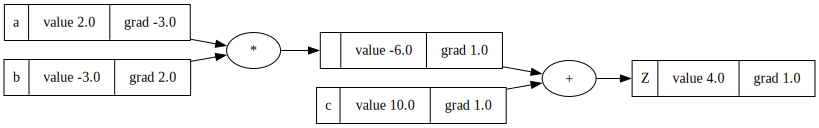

In [10]:
# With the following one-liner, you can visualize the comp. graph
draw_graph(Z)

After understanding the previous example, you can start the exercise! We write down the equations here to make your life easier.
$$
\mathcal{A} = \sqrt{a + b + c^2} + \log(a + b + c^2) + \frac{a + b + c^2}{bc^2}
$$

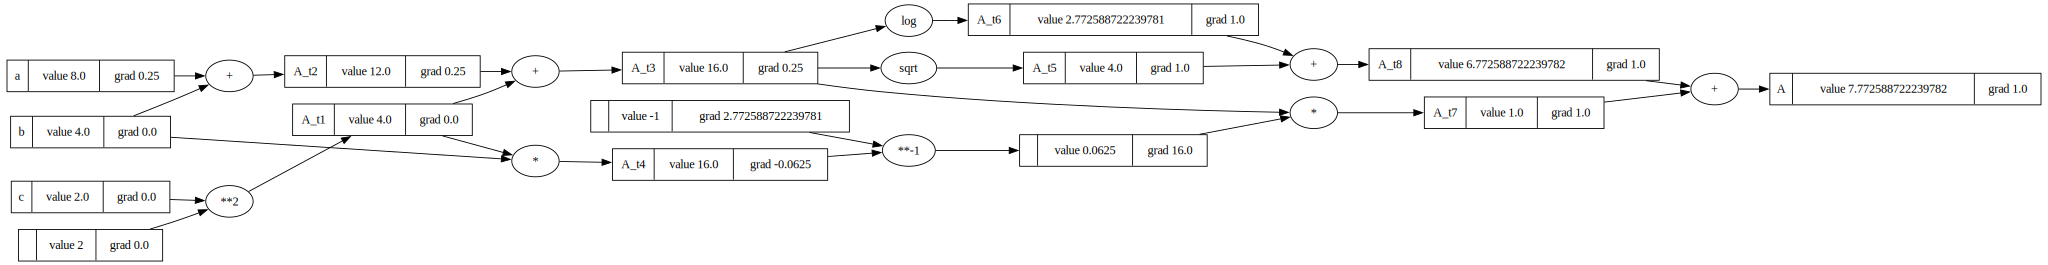

In [11]:
# Implement the equation A and compute the gradients here.
# Implement the equation B and compute the gradients here.

# Set dummy values for the independent variables
Aa = Node(8.0, label='a')
Ab = Node(4.0, label='b')
Ac = Node(2.0, label='c')

# Compute the intermediate variables
A_t1 = Ac ** 2;       A_t1.label='A_t1'
A_t2 = Aa + Ab;       A_t2.label='A_t2'
A_t3 = A_t1 + A_t2;   A_t3.label='A_t3'
A_t4 = Ab * A_t1;     A_t4.label='A_t4'
A_t5 = A_t3.sqrt();   A_t5.label='A_t5'
A_t6 = A_t3.log();    A_t6.label='A_t6'
A_t7 = A_t3 / A_t4;   A_t7.label='A_t7'
A_t8 = A_t5 + A_t6;   A_t8.label='A_t8'
A    = A_t7 + A_t8;   A.label='A'

# Backprop
A.backward()

# computation graph visualization
draw_graph(A)

$$
\mathcal{B} = \sum_{i=1}^{3}(w_0 + w_1x_i - y_i)^2
$$

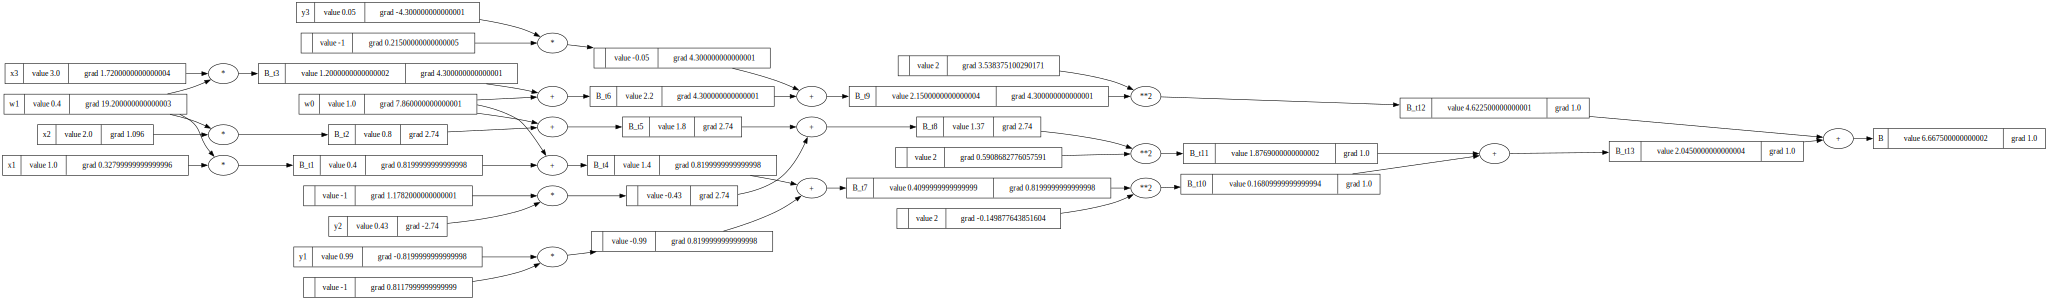

In [12]:
# Implement the equation B and compute the gradients here.
        
# Set dummy values for the independent variables
x1 = Node(1.0, label='x1')
x2 = Node(2.0, label='x2')
x3 = Node(3.0, label='x3')
w0 = Node(1.0, label='w0')
w1 = Node(0.4, label='w1')
y1 = Node(0.99,label='y1')
y2 = Node(0.43,label='y2')
y3 = Node(0.05,label='y3')


# Compute the intermediate variables
B_t1 = w1 * x1;         B_t1.label='B_t1'
B_t2 = w1 * x2;         B_t2.label='B_t2'
B_t3 = w1 * x3;         B_t3.label='B_t3'
B_t4 = w0 + B_t1;       B_t4.label='B_t4'
B_t5 = w0 + B_t2;       B_t5.label='B_t5'
B_t6 = w0 + B_t3;       B_t6.label='B_t6'
B_t7 = B_t4 - y1;       B_t7.label='B_t7'
B_t8 = B_t5 - y2;       B_t8.label='B_t8'
B_t9 = B_t6 - y3;       B_t9.label='B_t9'
B_t10= B_t7 ** 2;       B_t10.label='B_t10'
B_t11= B_t8 ** 2;       B_t11.label='B_t11'
B_t12= B_t9 ** 2;       B_t12.label='B_t12'
B_t13= B_t10 + B_t11;   B_t13.label='B_t13'
B    = B_t12 + B_t13;   B.label='B'

# Compute the backpropagation
B.backward()

# Draw the comp. graph
draw_graph(B)